Mounted at /content/drive
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Linear-5                  [-1, 128]      12,845,184
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 2]             258
Total params: 12,850,530
Trainable params: 12,850,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 11.49
Params size (MB): 49.02
Estimated Total Size (MB): 61.08
----------------------------------------------------------------
Epoch 1/10, Train Loss: 0.7209701423461621, Validation Loss: 0.67659826

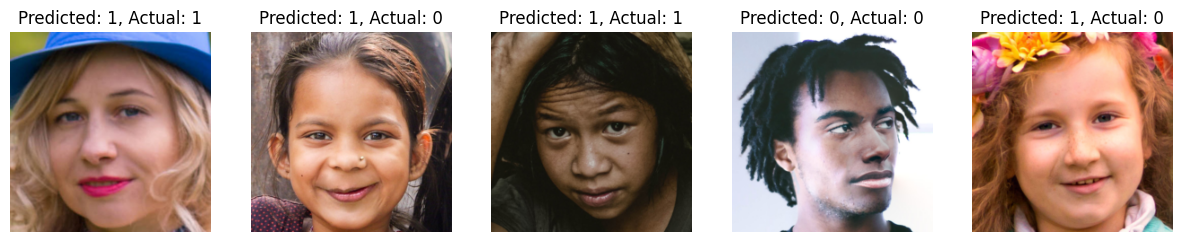

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchsummary import summary
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

# Configura la ruta de Google Drive donde se encuentran los datos
drive.mount('/content/drive', force_remount=True)

# Define transformaciones para normalizar y convertir las imágenes en tensores
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Carga los datos desde Google Drive
google_drive_path = "/content/drive/MyDrive/real_and_fake_face"
dataset = ImageFolder(root=google_drive_path, transform=transform)

# Divide los datos en conjuntos de entrenamiento, validación y prueba
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Define el DataLoader para los conjuntos de entrenamiento, validación y prueba
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Construye el modelo CNN con Dropout y Regularización L2
class FaceClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5, weight_decay=5e-5):  # Aumenta el valor de weight_decay
        super(FaceClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instancia el modelo y muestra un resumen
model = FaceClassifier()
summary(model, (3, 224, 224))

# Define la función de pérdida y el optimizador con aumento de weight_decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-5)  # Aumenta el valor de weight_decay

# División del conjunto de entrenamiento en entrenamiento y validación
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

# Define el DataLoader para el conjunto de entrenamiento y validación
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

# Define la función para evaluar el modelo en un conjunto de datos
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Establece el modelo en modo de evaluación
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, current_loss):
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Deteniendo el entrenamiento. No hay mejora en la pérdida de validación.")
                return True
        return False

# Función de entrenamiento con early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, early_stopping, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        # Calcular la pérdida y precisión en el conjunto de validación
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)

        # Imprimir las tasas de pérdida y precisión en el conjunto de entrenamiento y validación
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_train_loss/len(train_loader)}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy * 100:.2f}%')

        # Verificar early stopping
        if early_stopping(val_loss):
            break

    # Evaluación final en el conjunto de prueba
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
    print(f'Final Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100:.2f}%')

# Configurar early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Entrenamiento y evaluación del modelo con early stopping
train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, early_stopping, num_epochs=10)

# Función para visualizar predicciones
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        img = images[i].cpu().numpy().transpose((1, 2, 0)) / 2 + 0.5  # Desnormalizar
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'Predicted: {predicted[i]}, Actual: {labels[i]}')

    plt.show()

# Llamada a la función para visualizar predicciones con 5 imágenes
visualize_predictions(model, test_loader, num_images=5)



# Práctica de Detección de Rostros Reales y Falsos con Redes Neuronales Convolucionales (CNN) en PyTorch

**Objetivo:** Desarrollar un modelo de clasificación basado en una CNN para distinguir entre imágenes de rostros reales y falsificados por expertos.

**Introducción:**
En la era digital, el uso de imágenes falsificadas ha ido en aumento, especialmente en las redes sociales. La identificación de estas imágenes es crucial para garantizar la autenticidad de la información. Aunque existen modelos generativos como las GANs que pueden producir rostros falsos, los falsificadores humanos utilizan técnicas distintas que a menudo desafían a los modelos automáticos.

**Datos:**
Se proporciona un conjunto de datos que contiene imágenes de rostros, tanto reales como modificadas por expertos. Las imágenes falsificadas se dividen en tres categorías según su dificultad de detección: fácil, medio y difícil. [Enlace al conjunto de datos](https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection).

**Instrucciones:**

1. **Preprocesamiento de Datos:**
   - Descarga y descomprime el conjunto de datos.
   - Divide los datos en conjuntos de entrenamiento y prueba.
   - Normaliza las imágenes y conviértelas en tensores.

2. **Construcción del Modelo:**
   - Diseña una CNN para clasificar imágenes de rostros reales y falsificados.
   - Añade capas totalmente conectadas al final para la clasificación.

3. **Entrenamiento:**
   - Define una función de pérdida y un optimizador.
   - Entrena el modelo usando el conjunto de entrenamiento.
   - Evalúa el rendimiento del modelo en el conjunto de prueba tras cada época.

4. **Evaluación:**
   - Utiliza el Accuracy para evaluar el rendimiento del modelo.
   - Visualiza algunas predicciones del modelo para entender sus aciertos y errores.

5. **Conclusión:**
   - Discute los resultados obtenidos.
   - Sugerencias para mejorar el rendimiento del modelo.

6. **Extras:**
   - Explora diferentes arquitecturas de CNN.
   - Usas otras métricas de evaluación (F1, Precision, Recall, etc.)
   - Utiliza técnicas de aumento de datos para mejorar el rendimiento del modelo.
   - Buscar otros conjuntos de datos extras para entrenar el modelo.
   - Utiliza técnicas de regularización para evitar el sobreajuste del modelo.
   - Transfer Learning: Utiliza un modelo pre-entrenado para mejorar el rendimiento del modelo.
   - Usar otras liberias de Deep Learning como pytorch-lightning o wandb
   - Usar liberias de optimización como optuna, etc.
   - ...

7. **Competición:**
   - Un punto extra se otorgará a los 3 mejores modelos de la clase.
   - Gana el modelo que obtenga el Accuracy más alto en un conjunto de datos de prueba oculto, que ya os pasaré
   - No uses ese conjunto de datos para entrenar tu modelo, solo para evaluarlo al final !!

**Entregables:**
- Código fuente en Python del modelo.
- Un informe detallando el diseño del modelo, resultados, conclusiones y recomendaciones.
- **Lo quiero todo subido a un repositorio en GitHub.**